In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing
import optuna
import cma

Only `cma.purecma` has been imported. Install `numpy` ("pip install numpy") if you want to import the entire `cma` package.


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m = pd.read_csv("../../data/processed/processed_3.csv")

In [3]:
m

,감독,제작사,배급사,전국 스크린수,전국 관객수,개봉년,국적_기타,국적_독일,국적_러시아,국적_미국,...,장르_어드벤처,장르_전쟁,장르_코미디,장르_판타지,등급_12세이상관람가,등급_15세이상관람가,등급_전체관람가,등급_청소년관람불가,영화구분_독립/예술영화,영화구분_일반영화
0,32994955.0,25901788.0,135690.0,1587.0,17613682.0,2014,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,20493037.0,16264944.0,135690.0,1978.0,16264944.0,2019,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
2,36480785.0,26664001.0,77594.0,1912.0,14410754.0,2017,False,False,False,False,...,False,False,False,True,True,False,False,False,False,True
3,28965892.0,40748216.0,135690.0,966.0,14245998.0,2014,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,33853565.0,80052717.0,56165.0,2835.0,13934592.0,2019,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,27757.0,5960.0,3918.0,166.0,5960.0,2020,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2288,30209.0,30209.0,599.0,91.0,6876.0,2021,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2289,3190.0,449249.0,65.0,65.0,3190.0,2021,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2290,555565.0,458271.0,87405.0,699.0,360873.0,2021,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [4]:
# 변수 제거 함수
def recursive_feature_elimination(X, y, model, min_features=1, verbose=True):
    # 초기 변수 개수
    n_features = X.shape[1]
    
    # 현재 변수들의 성능
    best_score = float("inf")
    best_features = X.columns.tolist()
    
    # 최소 변수 개수 이상인 경우
    while n_features > min_features:
        # 모든 변수에 대해 반복
        scores = []
        for feature in X.columns:
            # 선택한 변수 제외
            features = X.columns.drop(feature)
            X_new = X[features]
            
            # 모델 학습 및 평가
            model.fit(X_new, y)
            y_pred = model.predict(X_new)
            score = mean_squared_error(y, y_pred)
            scores.append(score)
            
        # 가장 성능이 좋은 변수 선택
        idx = pd.Index(scores).argmin()
        worst_feature = X.columns[idx]
        
        # 변수 제거
        X.drop(worst_feature, axis=1, inplace=True)
        n_features = X.shape[1]
        if verbose:
            print(f"Removing {worst_feature}: {n_features} features left")
        
        # 현재 변수 개수에서의 성능이 최선인 경우
        if min(scores) < best_score:
            best_score = min(scores)
            best_features = X.columns.tolist()
        else:
            break
    
    # 최종 선택된 변수들
    return best_features

# ElasticNetCV 모델 객체 생성
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
enet = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=5, max_iter=10000)

# 최소 변수 개수 지정
min_features = 5

# 재귀적 변수 제거 수행
X = m.drop("전국 관객수", axis=1)
y = m["전국 관객수"]
selected_features = recursive_feature_elimination(X, y, enet, min_features=min_features)

# 선택된 변수 출력
print(f"{len(selected_features)} features selected:")
print(selected_features)

Removing 장르_전쟁: 41 features left
Removing 국적_프랑스: 40 features left
41 features selected:
['감독', '제작사', '배급사', '전국 스크린수', '개봉년', '국적_기타', '국적_독일', '국적_러시아', '국적_미국', '국적_스페인', '국적_영국', '국적_일본', '국적_중국', '국적_캐나다', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_코미디', '장르_판타지', '등급_12세이상관람가', '등급_15세이상관람가', '등급_전체관람가', '등급_청소년관람불가', '영화구분_독립/예술영화', '영화구분_일반영화']


In [5]:
# 데이터 분할
X = m[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# KNeighborsRegressor 모델 학습
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# KNeighborsRegressor 모델 예측
knn_y_pred = knn.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, knn_y_pred, squared=False)
mae = mean_absolute_error(y_test, knn_y_pred)
r2 = r2_score(y_test, knn_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1046991.0399384358
MAE: 437052.3787790698
R-squared: 0.6283179069695868


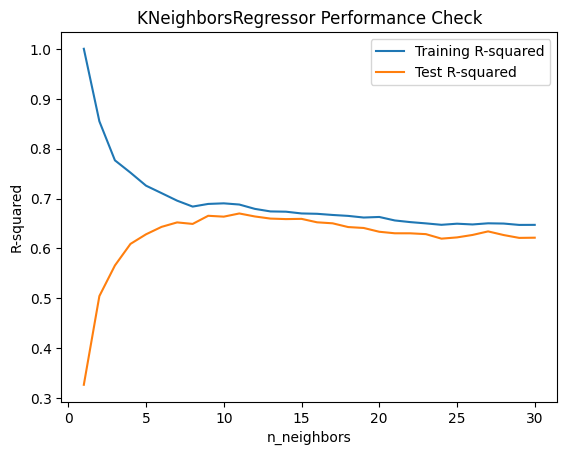

In [7]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_neighbors_range = range(1, 31)
for n_neighbors in n_neighbors_range:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, knn.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, knn.predict(X_test)))

plt.plot(n_neighbors_range, train_r2_scores, label="Training R-squared")
plt.plot(n_neighbors_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_neighbors")
plt.ylabel("R-squared")
plt.title("KNeighborsRegressor Performance Check")
plt.show()

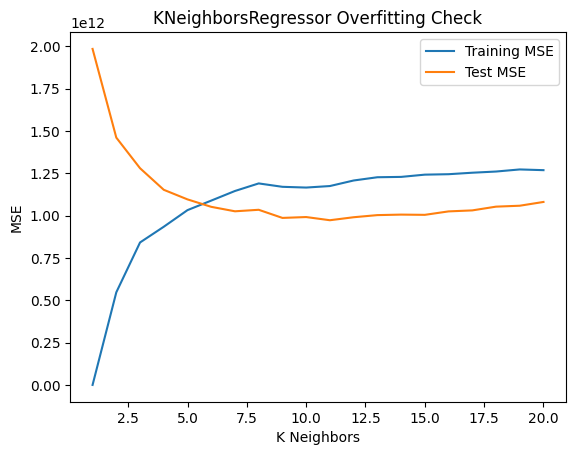

In [8]:
# 과적합 시각화
train_errors = []
test_errors = []
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_errors.append(mean_squared_error(y_train, knn.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, knn.predict(X_test)))

plt.plot(range(1, 21), train_errors, label="Training MSE")
plt.plot(range(1, 21), test_errors, label="Test MSE")
plt.xlabel("K Neighbors")
plt.ylabel("MSE")
plt.title("KNeighborsRegressor Overfitting Check")
plt.legend()
plt.show()

In [9]:
# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# RandomForestRegressor 모델 예측
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 725355.620059141
MAE: 284081.12338905036
R-squared: 0.8216029499643533


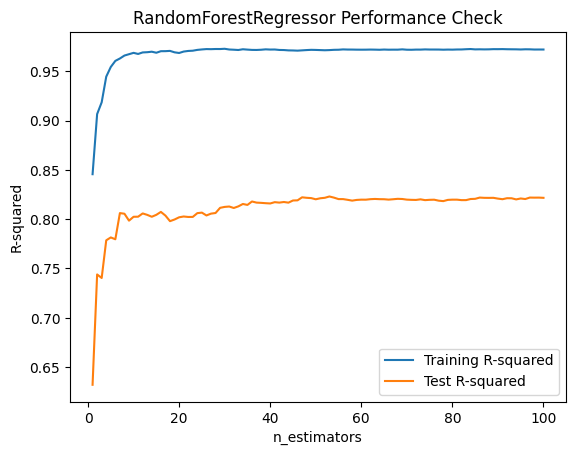

In [10]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, rf.n_estimators + 1)
for n_estimators in n_estimators_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, rf.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, rf.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("RandomForestRegressor Performance Check")
plt.show()

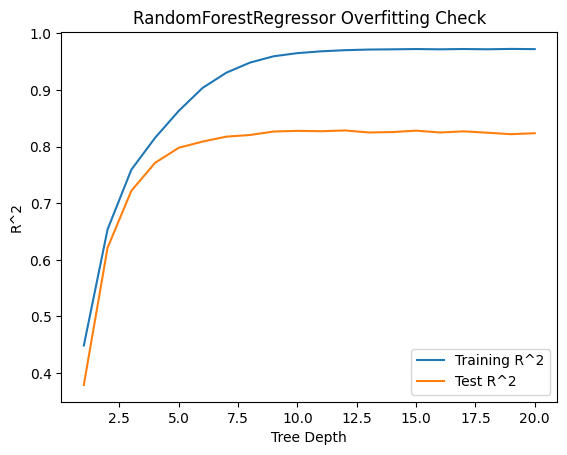

In [11]:
# 과적합 시각화
train_scores = []
test_scores = []

for depth in range(1, 21):
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

plt.plot(range(1, 21), train_scores, label="Training R-squared")
plt.plot(range(1, 21), test_scores, label="Test R-squared")
plt.xlabel("Tree Depth")
plt.ylabel("R^2")
plt.title("RandomForestRegressor Overfitting Check")
plt.legend()
plt.show()

In [98]:
def optimize_model(model_objective, n_trials=100):
    # Bayesian optimization 방식의 하이퍼파라미터 튜닝을 위해 Optuna 라이브러리 사용
    # 최소화를 목적으로 하기 때문에 'minimize'로 설정
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler())
    
    # 사용 가능한 모든 CPU 코어 수를 사용하여 병렬 처리
    n_jobs = multiprocessing.cpu_count()  
    
    # 모델 하이퍼파라미터 최적화 실행
    study.optimize(model_objective, n_trials=n_trials, n_jobs=n_jobs)
    
    # 최적 하이퍼파라미터와 그 때의 평가지표 출력
    print(f"Best RMSE: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
    
    # 최적 하이퍼파라미터 반환
    return study.best_params

In [99]:
# Random Forest 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    score = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Random Forest 모델의 하이퍼파라미터 최적화
rf_params = optimize_model(rf_objective)

[I 2023-05-12 15:28:35,073] A new study created in memory with name: no-name-626d823b-64f4-489f-a222-ad3a2ed3290b
[I 2023-05-12 15:28:51,290] Trial 3 finished with value: 1946266.8870696474 and parameters: {'n_estimators': 300, 'max_depth': 3}. Best is trial 3 with value: 1946266.8870696474.
[I 2023-05-12 15:28:54,165] Trial 1 finished with value: 1880657.3020691453 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 1 with value: 1880657.3020691453.
[I 2023-05-12 15:28:57,074] Trial 5 finished with value: 1864250.6090426832 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 5 with value: 1864250.6090426832.
[I 2023-05-12 15:29:21,474] Trial 6 finished with value: 1946286.7063293518 and parameters: {'n_estimators': 900, 'max_depth': 3}. Best is trial 5 with value: 1864250.6090426832.
[I 2023-05-12 15:29:27,772] Trial 0 finished with value: 1861677.8117909003 and parameters: {'n_estimators': 500, 'max_depth': 7}. Best is trial 0 with value: 1861677.811

Best RMSE: 1812823.5125
Best Parameters: {'n_estimators': 400, 'max_depth': 10}


In [100]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
rf.set_params(**rf_params)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 709996.1122369375
MAE: 279993.6147528367
R-squared: 0.829078124636002


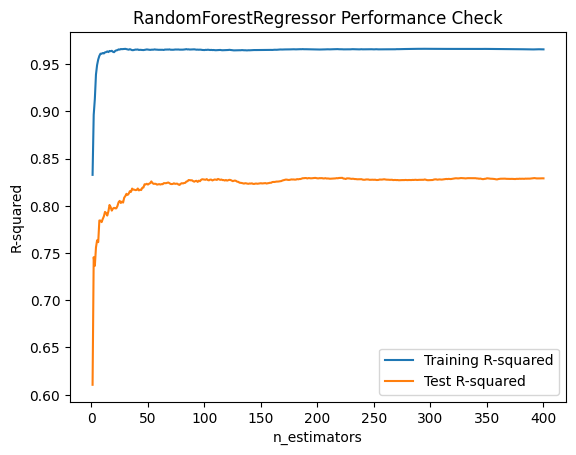

In [53]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, rf.n_estimators + 1)
for n_estimators in n_estimators_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, rf.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, rf.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("RandomForestRegressor Performance Check")
plt.show()

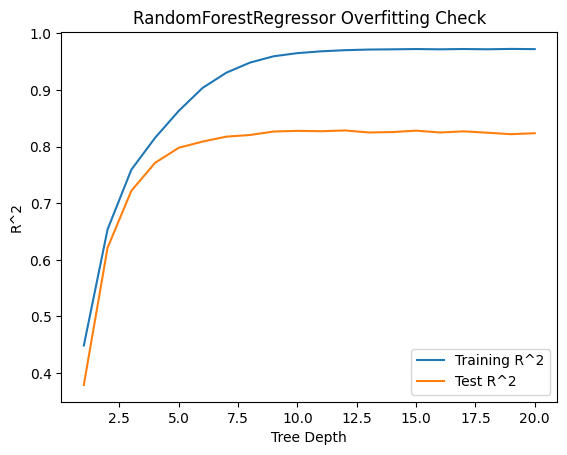

In [54]:
# 과적합 시각화
train_scores = []
test_scores = []

for depth in range(1, 21):
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

plt.plot(range(1, 21), train_scores, label="Training R-squared")
plt.plot(range(1, 21), test_scores, label="Test R-squared")
plt.xlabel("Tree Depth")
plt.ylabel("R^2")
plt.title("RandomForestRegressor Overfitting Check")
plt.legend()
plt.show()

In [60]:
# GradientBoostingRegressor 모델 학습
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# GradientBoostingRegressor 모델 예측
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 808769.6968899767
MAE: 378104.9729737434
R-squared: 0.7782133253702681


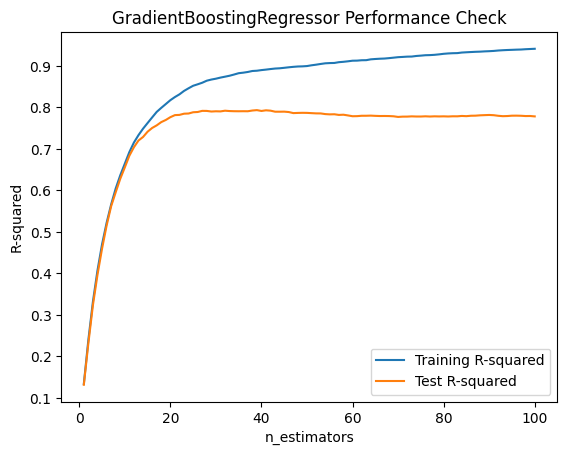

In [13]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, gb.n_estimators + 1)
for n_estimators in n_estimators_range:
    gb.n_estimators = n_estimators
    gb.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, gb.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, gb.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("GradientBoostingRegressor Performance Check")
plt.show()

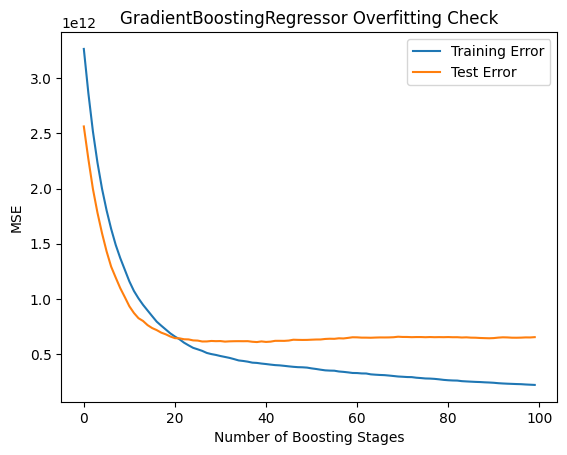

In [14]:
# 과적합 시각화
train_scores = []
test_scores = []
for i, y_pred in enumerate(gb.staged_predict(X_train)):
    train_scores.append(mean_squared_error(y_train, y_pred))
    test_scores.append(mean_squared_error(y_test, list(gb.staged_predict(X_test))[i]))

plt.plot(train_scores, label="Training Error")
plt.plot(test_scores, label="Test Error")
plt.xlabel("Number of Boosting Stages")
plt.ylabel("MSE")
plt.title("GradientBoostingRegressor Overfitting Check")
plt.legend()
plt.show()

In [93]:
# Gradient Boosting 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def gb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    gb = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                   max_depth=max_depth, random_state=42)
    score = cross_val_score(gb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Gradient Boosting 모델의 하이퍼파라미터 최적화
gb_params = optimize_model(gb_objective)

In [61]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
gb.set_params(**gb_params)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 756283.5317156799
MAE: 310965.3811052745
R-squared: 0.8060655355388766


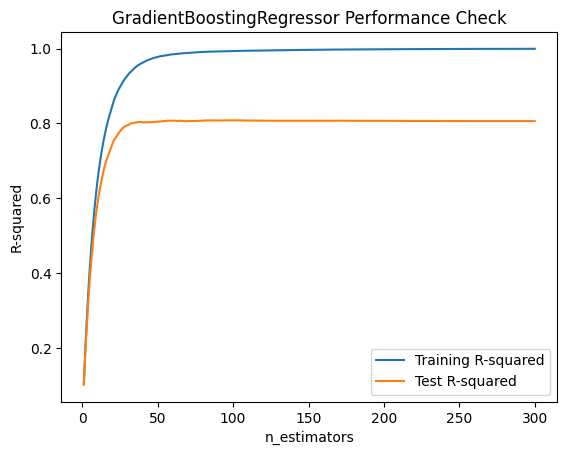

In [62]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, gb.n_estimators + 1)
for n_estimators in n_estimators_range:
    gb.n_estimators = n_estimators
    gb.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, gb.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, gb.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("GradientBoostingRegressor Performance Check")
plt.show()

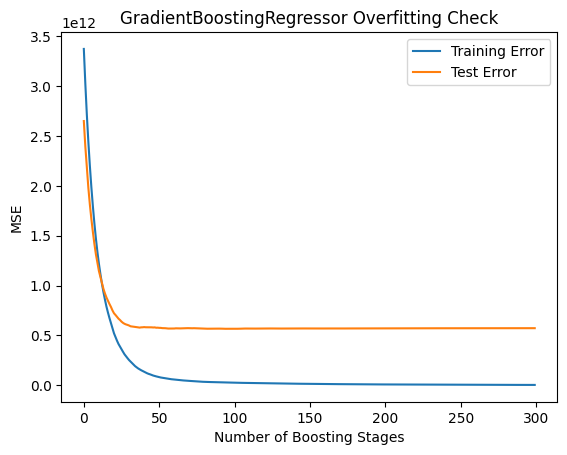

In [63]:
# 과적합 시각화
train_scores = []
test_scores = []
for i, y_pred in enumerate(gb.staged_predict(X_train)):
    train_scores.append(mean_squared_error(y_train, y_pred))
    test_scores.append(mean_squared_error(y_test, list(gb.staged_predict(X_test))[i]))

plt.plot(train_scores, label="Training Error")
plt.plot(test_scores, label="Test Error")
plt.xlabel("Number of Boosting Stages")
plt.ylabel("MSE")
plt.title("GradientBoostingRegressor Overfitting Check")
plt.legend()
plt.show()

In [15]:
# XGBRegressor 모델 학습
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# XGBRegressor 모델 예측
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 769067.1712450981
MAE: 309293.0682104244
R-squared: 0.7994538843939438


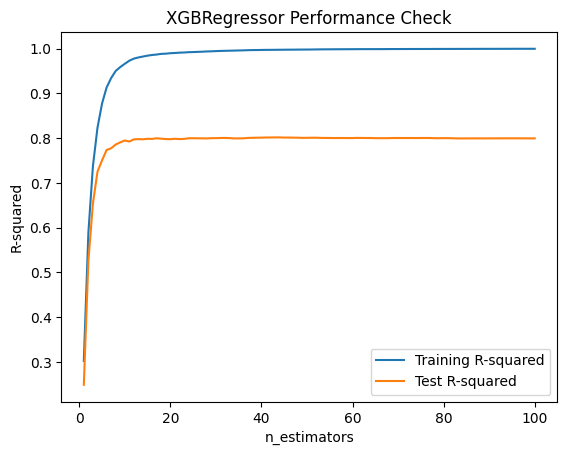

In [16]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, xgb.n_estimators + 1)
for n_estimators in n_estimators_range:
    xgb.n_estimators = n_estimators
    xgb.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, xgb.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, xgb.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("XGBRegressor Performance Check")
plt.show()

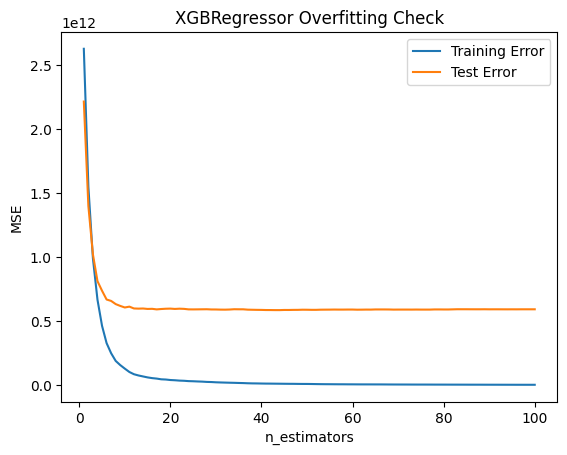

In [17]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, xgb.n_estimators + 1)
for n_estimators in n_estimators_range:
    xgb.n_estimators = n_estimators
    xgb.fit(X_train, y_train, verbose=False)
    train_scores.append(mean_squared_error(y_train, xgb.predict(X_train)))
    test_scores.append(mean_squared_error(y_test, xgb.predict(X_test)))

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("XGBRegressor Overfitting Check")
plt.show()

In [94]:
# XGBoost 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth=max_depth, subsample=subsample, random_state=42)
    score = cross_val_score(xgb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse
    
# XGBoost 모델의 하이퍼파라미터 최적화
xgb_params = optimize_model(xgb_objective)

In [64]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
xgb.set_params(**xgb_params)
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 708127.9527162532
MAE: 308684.4811188454
R-squared: 0.8299764091080265


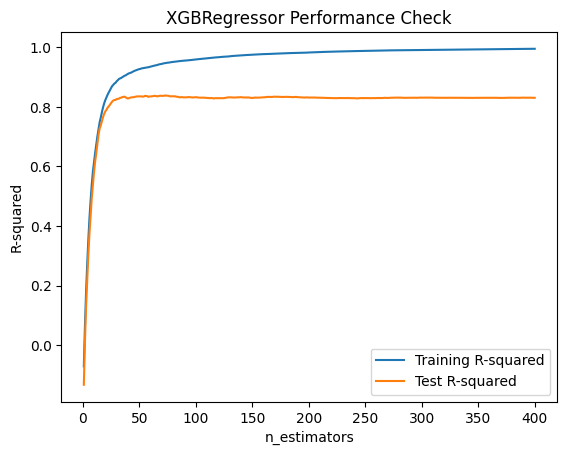

In [65]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, xgb.n_estimators + 1)
for n_estimators in n_estimators_range:
    xgb.n_estimators = n_estimators
    xgb.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, xgb.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, xgb.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("XGBRegressor Performance Check")
plt.show()

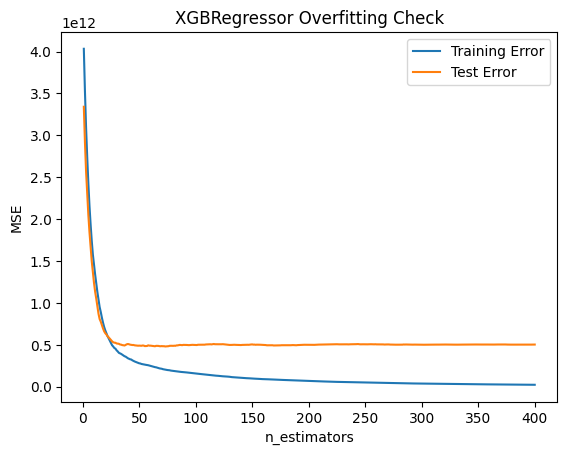

In [66]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, xgb.n_estimators + 1)
for n_estimators in n_estimators_range:
    xgb.n_estimators = n_estimators
    xgb.fit(X_train, y_train, verbose=False)
    train_scores.append(mean_squared_error(y_train, xgb.predict(X_train)))
    test_scores.append(mean_squared_error(y_test, xgb.predict(X_test)))

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("XGBRegressor Overfitting Check")
plt.show()

In [18]:
# LGBMRegressor 모델 학습
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# LGBMRegressor 모델 예측
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 728573.3408946604
MAE: 299436.4897870377
R-squared: 0.8200166794264664


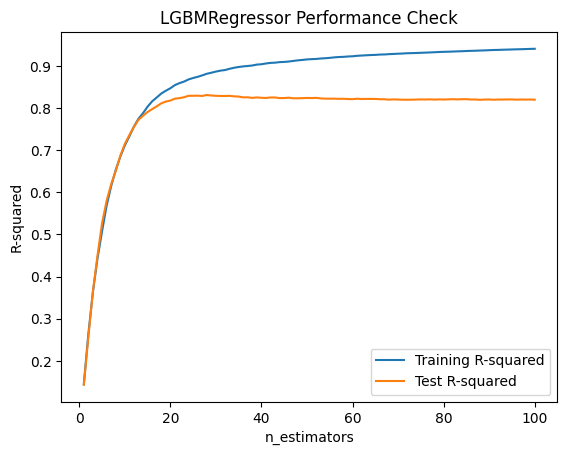

In [19]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, lgbm.n_estimators + 1)
for n_estimators in n_estimators_range:
    lgbm.n_estimators = n_estimators
    lgbm.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, lgbm.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, lgbm.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("LGBMRegressor Performance Check")
plt.show()

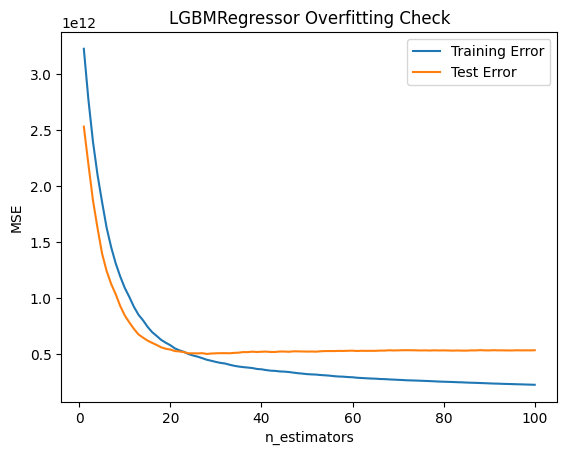

In [20]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, lgbm.n_estimators + 1)
for n_estimators in n_estimators_range:
    lgbm.n_estimators = n_estimators
    lgbm.fit(X_train, y_train)
    y_preds_train = lgbm.predict(X_train)
    y_preds_test = lgbm.predict(X_test)
    train_scores.append(mean_squared_error(y_train, y_preds_train, multioutput='raw_values'))
    test_scores.append(mean_squared_error(y_test, y_preds_test, multioutput='raw_values'))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

plt.plot(n_estimators_range, train_scores[:,0], label="Training Error")
plt.plot(n_estimators_range, test_scores[:,0], label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("LGBMRegressor Overfitting Check")
plt.show()

In [95]:
# LightGBM 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 10, 100)
    lgbm = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    max_depth=max_depth, num_leaves=num_leaves, random_state=42)
    score = cross_val_score(lgbm, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# LightGBM 모델의 하이퍼파라미터 최적화
lgbm_params = optimize_model(lgbm_objective)

In [67]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
lgbm.set_params(**lgbm_params)
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 756042.597213431
MAE: 357651.99673168483
R-squared: 0.8061890819573041


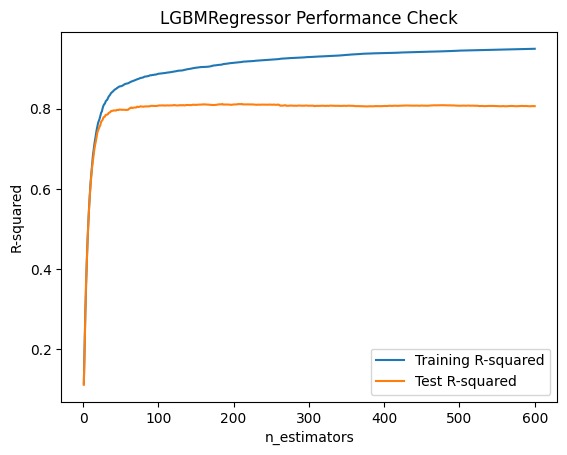

In [68]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, lgbm.n_estimators + 1)
for n_estimators in n_estimators_range:
    lgbm.n_estimators = n_estimators
    lgbm.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, lgbm.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, lgbm.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("LGBMRegressor Performance Check")
plt.show()

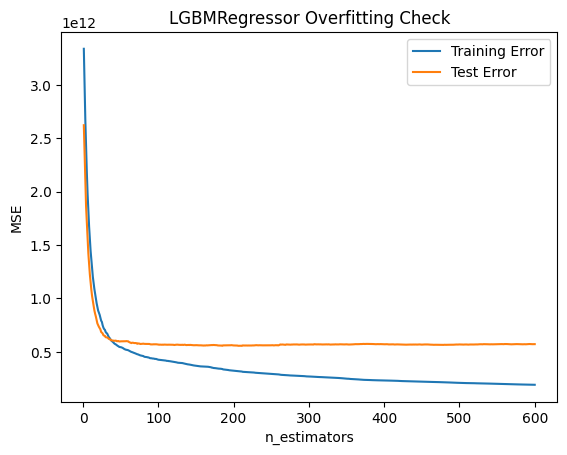

In [69]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, lgbm.n_estimators + 1)
for n_estimators in n_estimators_range:
    lgbm.n_estimators = n_estimators
    lgbm.fit(X_train, y_train)
    y_preds_train = lgbm.predict(X_train)
    y_preds_test = lgbm.predict(X_test)
    train_scores.append(mean_squared_error(y_train, y_preds_train, multioutput='raw_values'))
    test_scores.append(mean_squared_error(y_test, y_preds_test, multioutput='raw_values'))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

plt.plot(n_estimators_range, train_scores[:,0], label="Training Error")
plt.plot(n_estimators_range, test_scores[:,0], label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("LGBMRegressor Overfitting Check")
plt.show()

In [21]:
# ExtraTreesRegressor 모델 학습
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)

# ExtraTreesRegressor 모델 예측
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 730355.1421721608
MAE: 311802.54747819767
R-squared: 0.8191352673893766


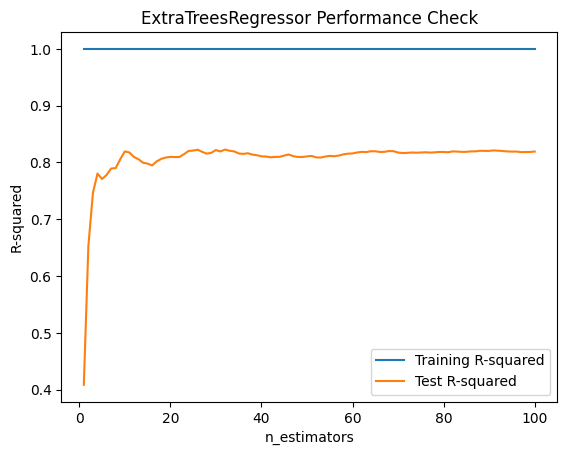

In [22]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, et.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, et.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("ExtraTreesRegressor Performance Check")
plt.show()

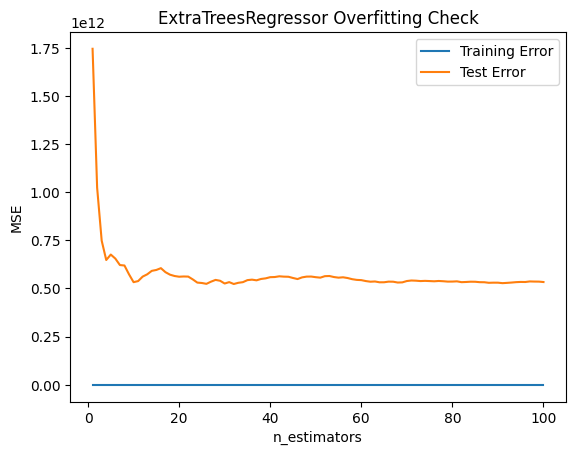

In [23]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    train_scores.append(mean_squared_error(y_train, et.predict(X_train)))
    test_scores.append(mean_squared_error(y_test, et.predict(X_test)))

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("ExtraTreesRegressor Overfitting Check")
plt.show()

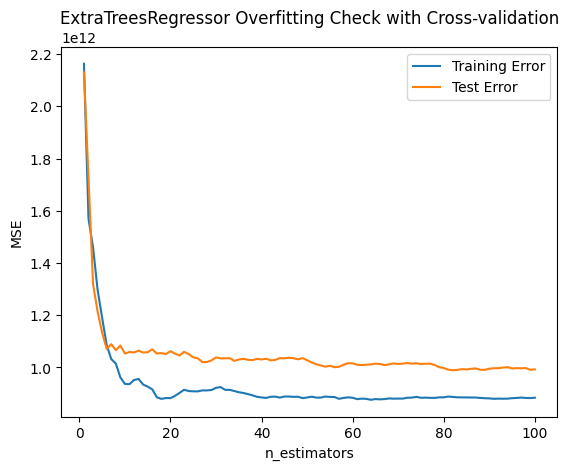

In [24]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    
    # 교차 검증 수행
    train_score = -cross_val_score(et, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    test_score = -cross_val_score(et, X_test, y_test, scoring='neg_mean_squared_error', cv=5).mean()
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("ExtraTreesRegressor Overfitting Check with Cross-validation")
plt.show()

In [96]:
# Extra Trees Regressor 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def et_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    et = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                             random_state=42)
    score = cross_val_score(et, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Extra Trees Regressor 모델의 하이퍼파라미터 최적화
et_params = optimize_model(et_objective)

In [70]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
et.set_params(**et_params)
et.fit(X_train, y_train)
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 729867.3591200275
MAE: 324047.62314273807
R-squared: 0.819376775350348


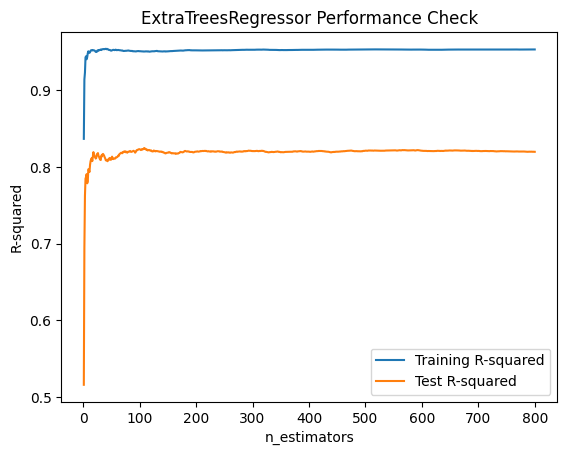

In [71]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, et.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, et.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("ExtraTreesRegressor Performance Check")
plt.show()

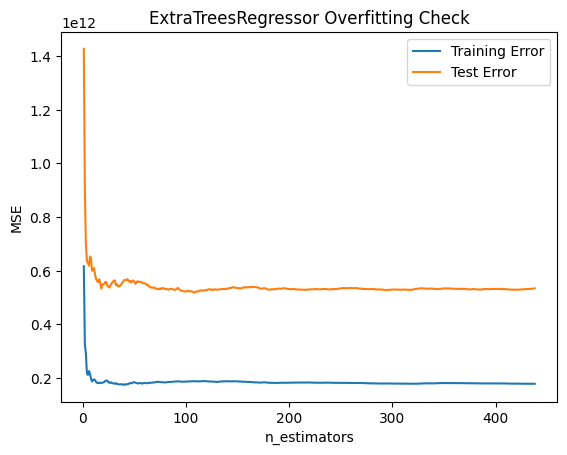

In [73]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    train_scores.append(mean_squared_error(y_train, et.predict(X_train)))
    test_scores.append(mean_squared_error(y_test, et.predict(X_test)))

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("ExtraTreesRegressor Overfitting Check")
plt.show()

In [ ]:
# 과적합 시각화
train_scores = []
test_scores = []
n_estimators_range = range(1, et.n_estimators + 1)
for n_estimators in n_estimators_range:
    et.n_estimators = n_estimators
    et.fit(X_train, y_train)
    
    # 교차 검증 수행
    train_score = -cross_val_score(et, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    test_score = -cross_val_score(et, X_test, y_test, scoring='neg_mean_squared_error', cv=5).mean()
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.plot(n_estimators_range, train_scores, label="Training Error")
plt.plot(n_estimators_range, test_scores, label="Test Error")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.title("ExtraTreesRegressor Overfitting Check with Cross-validation")
plt.show()

RMSE: 709996.1122369375
MAE: 279993.6147528367
R-squared: 0.829078124636002


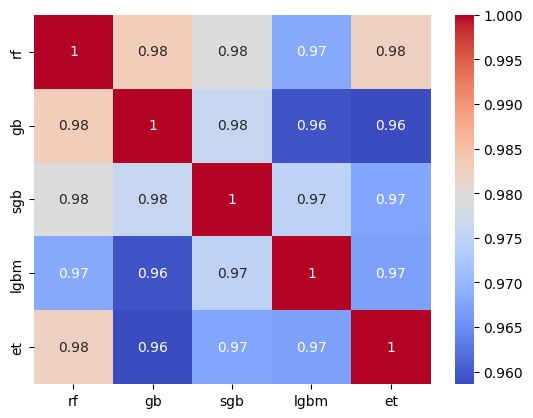

In [ ]:
# 각 모델에서 예측한 결과값을 변수로 갖는 데이터프레임 생성
pred_df = pd.DataFrame({
        "rf": rf_y_pred,
        "gb": gb_y_pred,
        "sgb": xgb_y_pred,
        "lgbm": lgbm_y_pred,
        "et" : et_y_pred
    })

# 상관 행렬 계산
corr_matrix = pred_df.corr()

# 시각화
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [75]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

best_model : GradientBoostingRegressor(learning_rate=0.061371924085513826, max_depth=6,
                          n_estimators=300, random_state=42)
RMSE: 784604.9209405944
MAE: 298494.4636782536
R-squared: 0.7912686109247766


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\skl

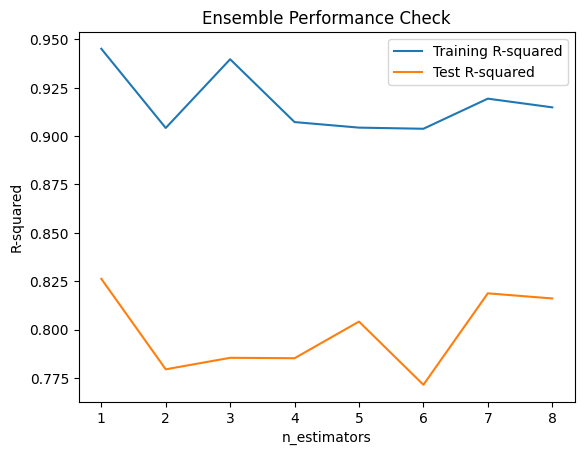

In [78]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, rf.n_estimators + 1)
for n_estimators in n_estimators_range:
    rf.n_estimators = n_estimators
    stack = StackingCVRegressor(
        regressors=[rf, gb, xgb, lgbm, et],
        meta_regressor=best_model,
        cv=5,
        use_features_in_secondary=True
    )
    stack.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, stack.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, stack.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("Ensemble Performance Check")
plt.show()

In [101]:
# 메타 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def meta_objective(trial):
    meta_model = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                                     meta_regressor=best_model,
                                     cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                     use_features_in_secondary=True)
    meta_model.set_params(meta_regressor=best_model,
                          meta_regressor__n_estimators=trial.suggest_int("n_estimators", 100, 1000, step=100),
                          meta_regressor__max_depth=trial.suggest_int("max_depth", 3, 10),
                          meta_regressor__min_samples_split=trial.suggest_int("min_samples_split", 2, 20))
    score = cross_val_score(meta_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(meta_objective, n_trials=100)

[I 2023-05-12 15:53:11,180] A new study created in memory with name: no-name-3bb1130b-2d8e-4c1c-86d9-b4940808b697
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegre

In [ ]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
stack.set_params(**stack_params)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


RMSE: 894079.1362167897
MAE: 361313.1292394851
R-squared: 0.72895735359082


In [ ]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, stack.n_estimators + 1)
for n_estimators in n_estimators_range:
    stack.n_estimators = n_estimators
    stack.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, stack.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, stack.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("Stacking Ensemble Performance Check")
plt.show()

In [ ]:
# X_train, X_test 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y_train, y_test 스케일링
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

In [ ]:
# 앙상블 모델 학습
stack.fit(X_train_scaled, y_train_scaled)

# 앙상블 모델 예측
y_pred = stack.predict(X_test_scaled)

# 평가지표 계산
rmse = mean_squared_error(y_test_scaled, y_pred, squared=False)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE: 0.047629749090319126
MAE: 0.01974565221447965
R-squared: 0.7613950902078808


In [ ]:
# 성능 시각화
train_r2_scores = []
test_r2_scores = []
n_estimators_range = range(1, stack.n_estimators + 1)
for n_estimators in n_estimators_range:
    stack.n_estimators = n_estimators
    stack.fit(X_train, y_train)
    train_r2_scores.append(r2_score(y_train, stack.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, stack.predict(X_test)))

plt.plot(n_estimators_range, train_r2_scores, label="Training R-squared")
plt.plot(n_estimators_range, test_r2_scores, label="Test R-squared")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("R-squared")
plt.title("Stacking Ensemble Performance Check")
plt.show()